COVID AND PNEUMONIA CLASSIFICATION

Dataset credits: 
https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/code?datasetId=576013&sortBy=voteCount

Import all dependencies and requirements

In [48]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Recall
import os

In [49]:
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  1
2.6.0


'3.9.18 (main, Sep 11 2023, 13:30:38) [MSC v.1916 64 bit (AMD64)]'

DATA COLLECTION AND PREPROCESSING

In [63]:
IMG_SIZE = 256
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS = 50

Import data into tensorflow dataset object

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [51]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    "Radiography_Dataset_test",
    seed=123,
    shuffle=True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    color_mode="rgb"
)

Found 4033 files belonging to 3 classes.


In [52]:
class_names = dataset.class_names
class_names

['COVID', 'NORMAL', 'PNEUMONIA']

In [7]:
# saving the class names as json file
import json
json.dump(class_names, open('class_indices.json', 'w'))

In [53]:
len(dataset)

64

In [54]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(64, 256, 256, 3)
[1 2 0 1 1 1 2 0 2 1 1 0 0 2 2 0 2 2 2 0 0 1 0 2 1 0 2 2 2 0 0 2 2 0 0 1 0
 2 1 2 1 0 2 1 1 0 2 2 2 2 1 2 0 1 1 2 0 2 1 0 1 2 2 0]


Visualize some images from the dataset

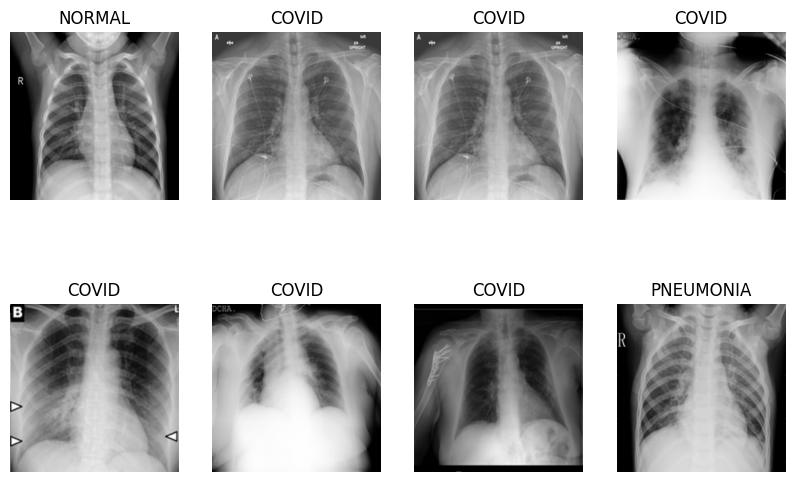

In [10]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

Split dataset into 3 subsets.

Train (80%)
Validation (10%)
Test (10%)

In [55]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)

    if shuffle: 
        ds = ds.shuffle(shuffle_size, seed=12)
                        
    train_size = int(train_split*ds_size) 
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size) 

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size) 
    
    return train_ds, val_ds, test_ds

In [56]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
len(train_ds)

51

In [14]:
len(val_ds)

6

In [15]:
len(test_ds)

7

Cache, Shuffle, and Prefetch the Dataset

In [57]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [58]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMG_SIZE,IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [59]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

BUILD THE MODEL

In [64]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [65]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (64, 256, 256, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (64, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (64, 127, 127, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (64, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (64, 62, 62, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (64, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (64, 30, 30, 64)         

In [66]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [67]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
51/51 [==============================] - 6s 73ms/step - loss: 1.4993 - accuracy: 0.6186 - val_loss: 0.4738 - val_accuracy: 0.8125
Epoch 2/50
51/51 [==============================] - 2s 39ms/step - loss: 0.3715 - accuracy: 0.8631 - val_loss: 0.3884 - val_accuracy: 0.8542
Epoch 3/50
51/51 [==============================] - 2s 39ms/step - loss: 0.2806 - accuracy: 0.9007 - val_loss: 0.2516 - val_accuracy: 0.9010
Epoch 4/50
51/51 [==============================] - 2s 39ms/step - loss: 0.2598 - accuracy: 0.9096 - val_loss: 0.2888 - val_accuracy: 0.8828
Epoch 5/50
51/51 [==============================] - 2s 39ms/step - loss: 0.2189 - accuracy: 0.9314 - val_loss: 0.1739 - val_accuracy: 0.9349
Epoch 6/50
51/51 [==============================] - 2s 39ms/step - loss: 0.1646 - accuracy: 0.9452 - val_loss: 0.1846 - val_accuracy: 0.9271
Epoch 7/50
51/51 [==============================] - 2s 39ms/step - loss: 0.1548 - accuracy: 0.9476 - val_loss: 0.1484 - val_accuracy: 0.9505
Epoch 8/50
51

In [68]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 2s 16ms/step - loss: 0.0290 - accuracy: 0.9933


In [24]:
scores

[0.04428049921989441, 0.9955357313156128]

In [25]:
history.params

{'verbose': 1, 'epochs': 60, 'steps': 51}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
type(history.history['loss'])

list

In [28]:
len(history.history['loss'])

60

In [29]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.4292300939559937,
 0.3014838993549347,
 0.2559494078159332,
 0.20256182551383972,
 0.2229747176170349]

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

PLOT ACCURACCY AND LOSS CURVES

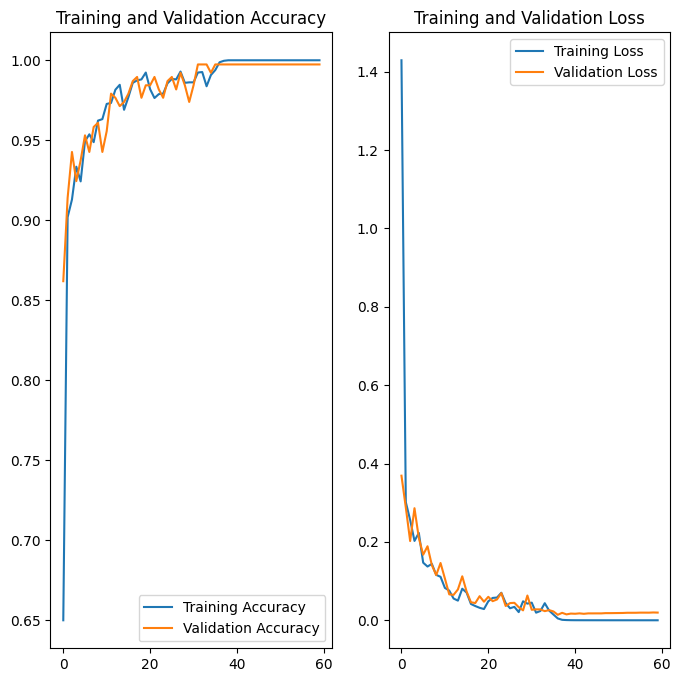

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: NORMAL
predicted label: NORMAL


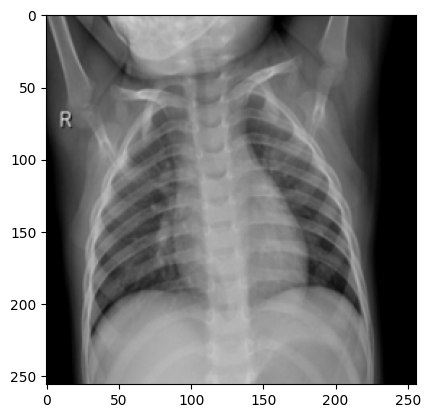

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

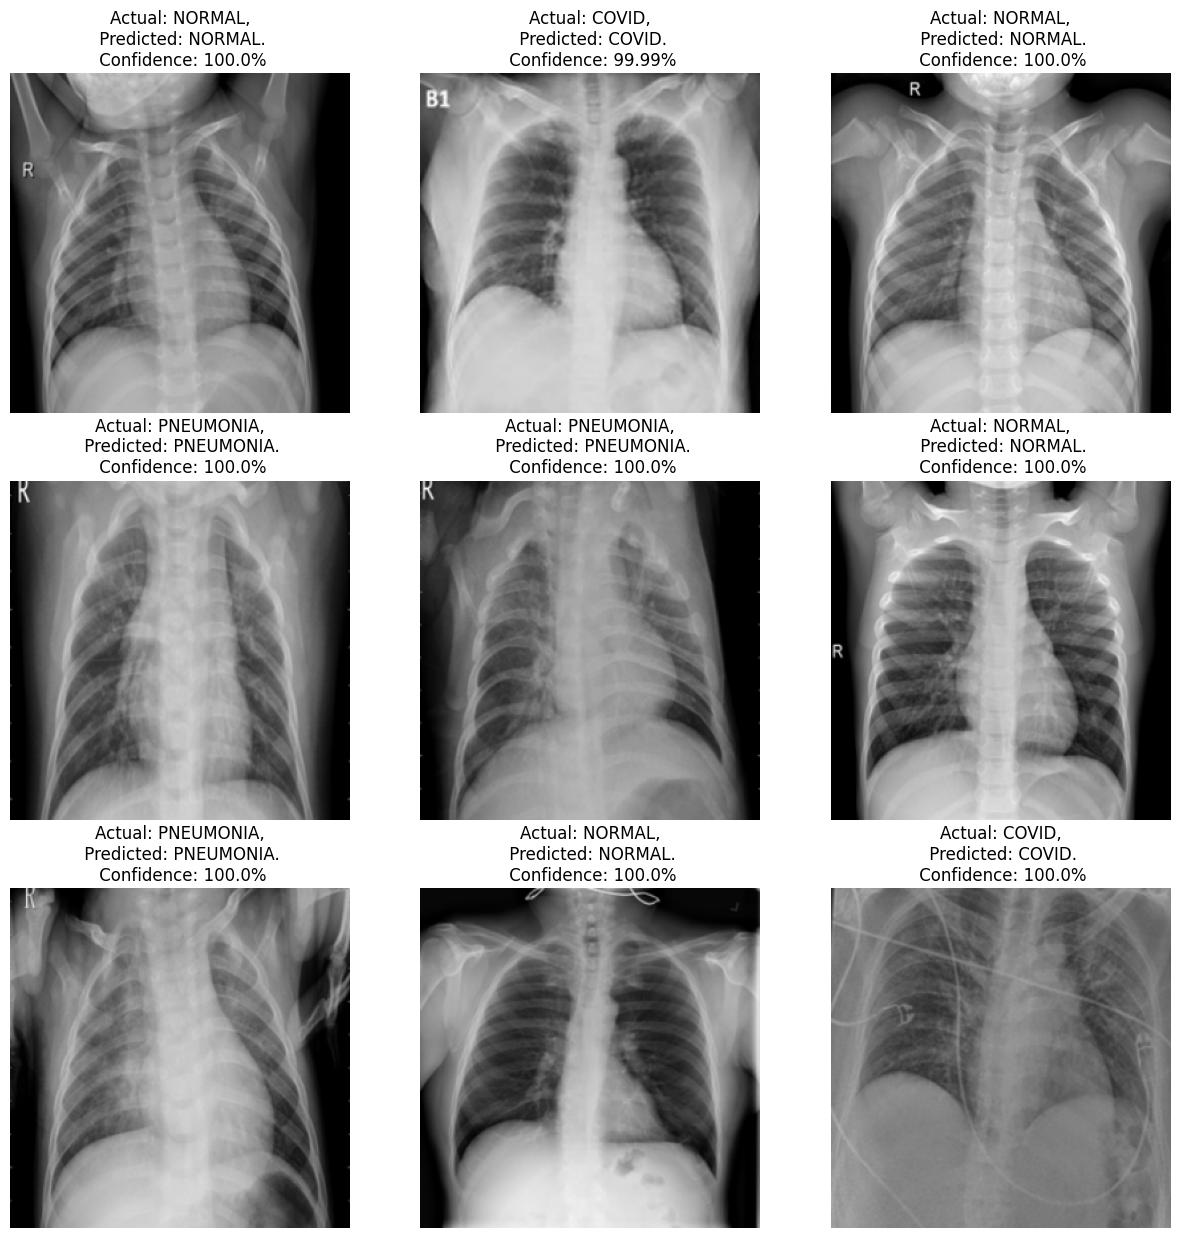

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [41]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


In [69]:
model.save("model_v6.h5")

In [70]:
model.save_weights('weight_v6.h5')

In [44]:
class_names

['COVID', 'NORMAL', 'PNEUMONIA']

<Figure size 800x600 with 0 Axes>

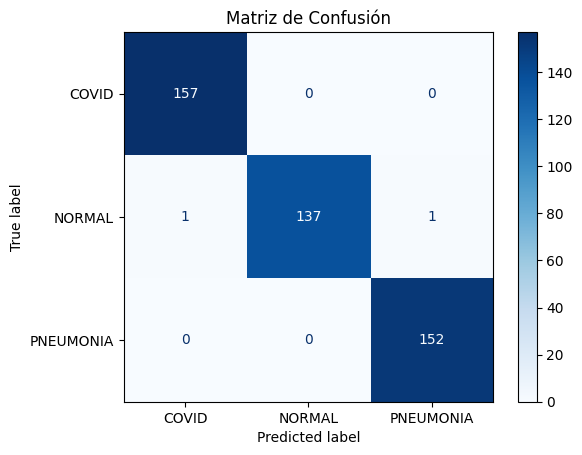

In [45]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())  
    y_pred.extend(np.argmax(predictions, axis=-1))  

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

In [5]:
from keras.models import load_model
model=load_model('model_v4.h5')

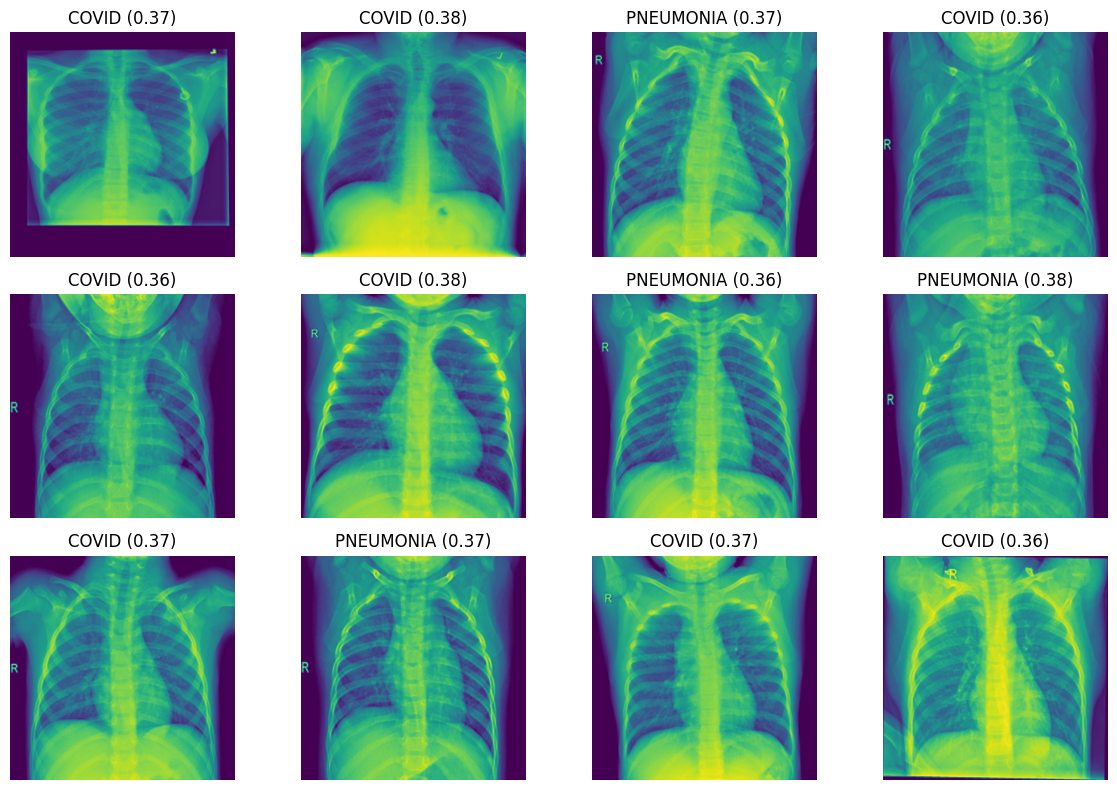

In [47]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import load_model

class_names = json.load(open(f"class_indices.json"))

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0 
    img_array = np.expand_dims(img_array, axis=0) 
    return img_array

def predict_image_class(model, image_array, class_names):
    predictions = model.predict(image_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]
    confidence_score = predictions[0][predicted_class_index]
    return predicted_class_name, confidence_score

test_dir = 'Radiography_Dataset_test/Normal/images'

results = []

for image_name in os.listdir(test_dir):
    image_path = os.path.join(test_dir, image_name)
    image_array = load_and_preprocess_image(image_path)
    predicted_class, confidence = predict_image_class(model, image_array, class_names)
    results.append((image_name, predicted_class, confidence))

plt.figure(figsize=(12, 8))
for i, (image_name, predicted_class, confidence) in enumerate(results[:12]):  # Mostrar solo las primeras 12
    img = Image.open(os.path.join(test_dir, image_name))
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"{predicted_class} ({confidence:.2f})")
    plt.axis('off')
plt.tight_layout()
plt.show()